# NLP for Yelp Tips

In [0]:
# importing required packages

import pandas_profiling
import numpy as np
import pandas as pd
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import seaborn as sns
import re, string
import sys
import time
import collections

In [2]:
# importing the data
df = pd.read_parquet('tip.parquet')

df.head()

,user_id,business_id,text,date,compliment_count
43058,yo74UdoRXo4-9W4_rw6OVQ,DkYS3arLOhA8si5uUEmHOw,The Italian sub didn't come with any lettuce. ...,2012-06-05 08:52:02,0
133912,UYcmGbelzRa0Q6JqzLoguw,QGAv-8tj5i4m4G-HDMnIbA,Service is horrible and skip the cake batter s...,2015-01-26 00:43:02,1
435180,xyOC6_uzW_H33j1XmjFitA,5S4qWTntF4S-JNTbPNyYPw,"Great place for coffee and to kick back and ""g...",2017-11-08 20:16:07,0
111024,CxDOIDnH8gp9KXzpBHJYXw,c6f8wBjPLDzyubEBqgcMnw,No washroom.... Hold.. Hold.. Hold..,2013-02-12 18:30:20,0
768408,_VOxmPH8tdGQS3D7TMGFQg,DVfCbJhJUDWRlUfrKzaKOA,This is so great. Restaurant in front and MSG ...,2016-12-20 06:19:51,0


In [3]:
# descriptive statistics
df.describe()

,compliment_count
count,104538.000000
mean,0.016807
std,0.146757
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,7.000000


In [4]:
# utilize PP
pandas_profiling.ProfileReport(df)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,6
Number of observations,104538
Total Missing (%),0.0%
Total size in memory,4.8 MiB
Average record size in memory,48.0 B
Numeric,2
Categorical,3
Boolean,0
Date,1
Text (Unique),0
Rejected,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104538 entries, 43058 to 658121
Data columns (total 5 columns):
user_id             104538 non-null object
business_id         104538 non-null object
text                104538 non-null object
date                104538 non-null datetime64[ns]
compliment_count    104538 non-null int64
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 4.8+ MB


In [0]:
# add a tip length column to make sure users are leaving meaningful tips 

df['tip_length'] = df['text'].apply(len)

In [7]:
df.head()

,user_id,business_id,text,date,compliment_count,tip_length
43058,yo74UdoRXo4-9W4_rw6OVQ,DkYS3arLOhA8si5uUEmHOw,The Italian sub didn't come with any lettuce. ...,2012-06-05 08:52:02,0,67
133912,UYcmGbelzRa0Q6JqzLoguw,QGAv-8tj5i4m4G-HDMnIbA,Service is horrible and skip the cake batter s...,2015-01-26 00:43:02,1,77
435180,xyOC6_uzW_H33j1XmjFitA,5S4qWTntF4S-JNTbPNyYPw,"Great place for coffee and to kick back and ""g...",2017-11-08 20:16:07,0,66
111024,CxDOIDnH8gp9KXzpBHJYXw,c6f8wBjPLDzyubEBqgcMnw,No washroom.... Hold.. Hold.. Hold..,2013-02-12 18:30:20,0,36
768408,_VOxmPH8tdGQS3D7TMGFQg,DVfCbJhJUDWRlUfrKzaKOA,This is so great. Restaurant in front and MSG ...,2016-12-20 06:19:51,0,66


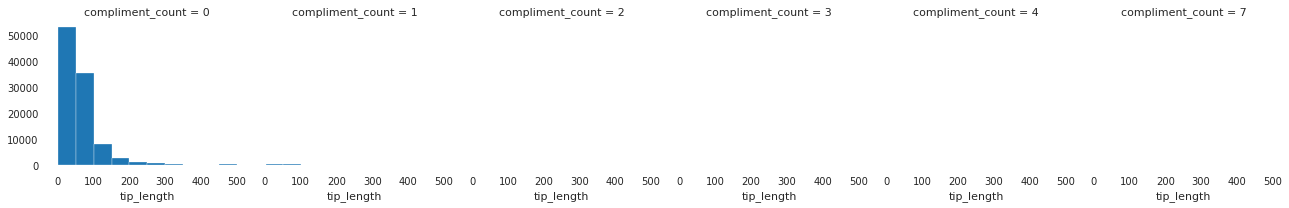

In [8]:
# Look at the tip lengths by compliment count

import matplotlib.pyplot as plt

sns.set_style('white')
%matplotlib inline
g = sns.FacetGrid(df,col='compliment_count')
g.map(plt.hist,'tip_length')

Most people don't give compliments 

In [0]:
# Seperate the text in tips

tips = df.text

##Tokenizing and N-grams

In [0]:
# Tokenizing function 
def tokenize(s):
    """Convert string to lowercase and split into words (ignoring
    punctuation), returning list of words.
    """
    word_list = re.findall(r'\w+', s.lower())
    filtered_words = [word for word in word_list if word not in stopwords.words('english')]
    return filtered_words

# Counting ngram function
def count_ngrams(lines, min_length=2, max_length=4):
    """Iterate through given lines iterator (file object or list of
    lines) and return n-gram frequencies. The return value is a dict
    mapping the length of the n-gram to a collections.Counter
    object of n-gram tuple and number of times that n-gram occurred.
    Returned dict includes n-grams of length min_length to max_length.
    """
    lengths = range(min_length, max_length + 1)
    ngrams = {length: collections.Counter() for length in lengths}
    queue = collections.deque(maxlen=max_length)

# Helper function to add n-grams at start of current queue to dict
    def add_queue():
        current = tuple(queue)
        for length in lengths:
            if len(current) >= length:
                ngrams[length][current[:length]] += 1

# Loop through all lines and words and add n-grams to dict
    for line in lines:
        for word in tokenize(line):
            queue.append(word)
            if len(queue) >= max_length:
                add_queue()

# Make sure we get the n-grams at the tail end of the queue
    while len(queue) > min_length:
        queue.popleft()
        add_queue()
        return ngrams

# for most frequent
def print_most_frequent(ngrams, num=10):
    """Print num most common n-grams of each length in n-grams dict."""
    for n in sorted(ngrams):
        print('----- {} most common {}-word phrase -----'.format(num, n))
        for gram, count in ngrams[n].most_common(num):
            print('{0}: {1}'.format(' '.join(gram), count))
        print('')

# for word cloud
def print_word_cloud(ngrams, num=5):
    """Print word cloud image plot """
    words = []
    for n in sorted(ngrams):
        for gram, count in ngrams[n].most_common(num):
            s = ' '.join(gram)
            words.append(s)
            
    cloud = WordCloud(width=1440, height= 1080,max_words= 200).generate(' '.join(words))
    plt.figure(figsize=(20, 15))
    plt.imshow(cloud)
    plt.axis('off');
    plt.show()
    print('')

In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
# Add tonekize column 

df['tokens'] = df['text'].apply(tokenize)

df.head()

,user_id,business_id,text,date,compliment_count,tip_length,tokens
43058,yo74UdoRXo4-9W4_rw6OVQ,DkYS3arLOhA8si5uUEmHOw,The Italian sub didn't come with any lettuce. ...,2012-06-05 08:52:02,0,67,"[italian, sub, come, lettuce, meat, tomato]"
133912,UYcmGbelzRa0Q6JqzLoguw,QGAv-8tj5i4m4G-HDMnIbA,Service is horrible and skip the cake batter s...,2015-01-26 00:43:02,1,77,"[service, horrible, skip, cake, batter, shakes..."
435180,xyOC6_uzW_H33j1XmjFitA,5S4qWTntF4S-JNTbPNyYPw,"Great place for coffee and to kick back and ""g...",2017-11-08 20:16:07,0,66,"[great, place, coffee, kick, back, grind, work]"
111024,CxDOIDnH8gp9KXzpBHJYXw,c6f8wBjPLDzyubEBqgcMnw,No washroom.... Hold.. Hold.. Hold..,2013-02-12 18:30:20,0,36,"[washroom, hold, hold, hold]"
768408,_VOxmPH8tdGQS3D7TMGFQg,DVfCbJhJUDWRlUfrKzaKOA,This is so great. Restaurant in front and MSG ...,2016-12-20 06:19:51,0,66,"[great, restaurant, front, msg, factory, back]"


## Let's test these tokens in a word cloud 

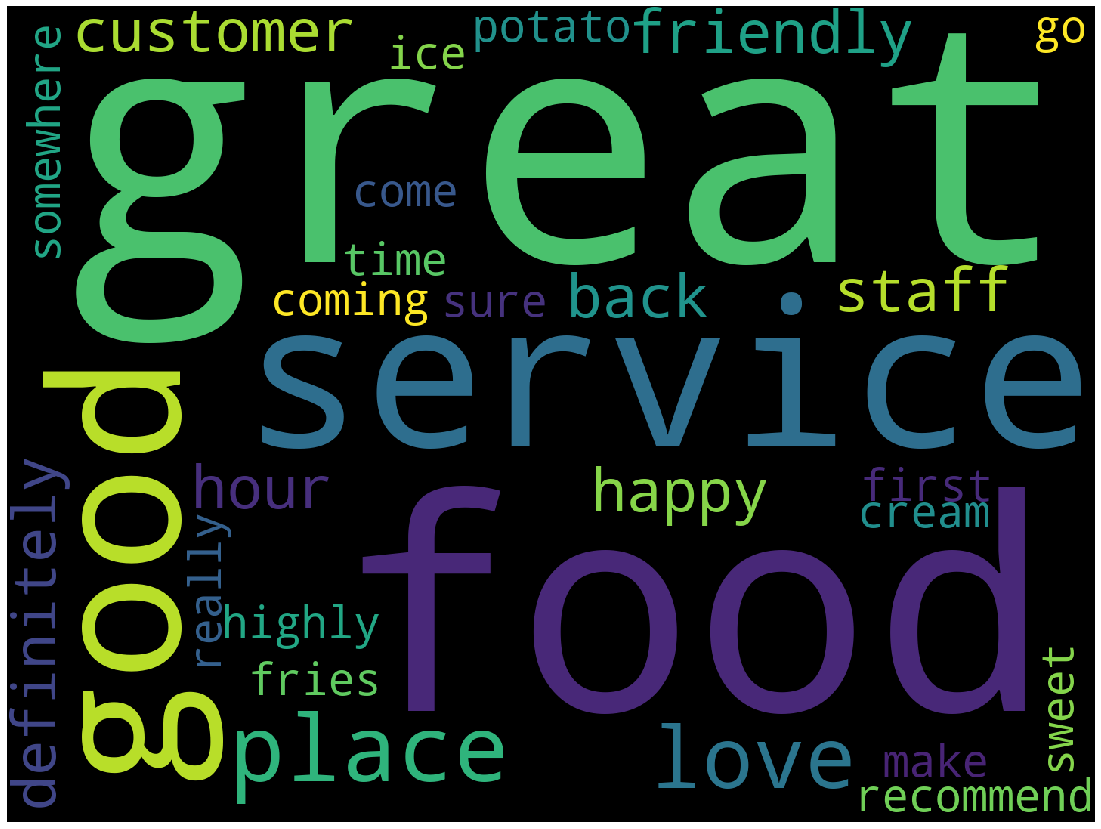


CPU times: user 2min 27s, sys: 17.4 s, total: 2min 44s
Wall time: 2min 44s


In [13]:
%%time
# Sample Tips 
most_frequent_tips = count_ngrams(tips,max_length=3)
print_word_cloud(most_frequent_tips, 20)

In [14]:
print_most_frequent(most_frequent_tips, num= 20)

----- 20 most common 2-word phrase -----
great food: 2097
great service: 1771
love place: 1339
good food: 1251
food great: 1244
happy hour: 1217
customer service: 1209
great place: 1196
service great: 804
friendly staff: 773
food good: 741
first time: 651
really good: 640
good service: 618
food service: 582
make sure: 558
ice cream: 542
place great: 513
highly recommend: 464
service good: 411

----- 20 most common 3-word phrase -----
great food great: 434
food great service: 388
great customer service: 325
great service great: 213
service great food: 193
great food service: 185
food good service: 175
good food good: 165
good food great: 129
service good food: 129
great happy hour: 127
love place great: 122
place great food: 116
love love love: 111
great place great: 89
food friendly staff: 81
definitely come back: 81
sweet potato fries: 81
definitely coming back: 81
go somewhere else: 80

